In [1]:
# Add the parent directory to the path so that we can import the necessary modules
%cd ..

/home/tourloid/Desktop/PhD/Code/SPVD


In [2]:
import torch
import torch.nn as nn
import numpy as np
from datasets.shapenet_pointflow import ShapeNet15kPointClouds
from datasets.utils import NoiseSchedulerDDPM
from torchsparse.utils.quantize import sparse_quantize
from torchsparse import SparseTensor

from torch.utils.data import DataLoader
from pclab.utils import DataLoaders
from torchsparse.utils.collate import sparse_collate_fn

from pclab.learner import *

from functools import partial
from utils.visualization import quick_vis_batch
vis_batch = partial(quick_vis_batch, x_offset = 8, y_offset=8)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
class ShapaNet15kNoisySparseSuperRes(ShapeNet15kPointClouds):

    def __init__(self, root_dir='./data/ShapeNetCore.v2.PC15k', categories=['chair'], pres=1e-5, #, 'car', 'airplane', 'table', 'bag'
                 noise_params={'beta_min':0.0001 ,'beta_max':0.02 , 'n_steps':1000},
                 high_res = 8192, low_res = 1024,
                 split='train',
                 random_subsample=False):
        super().__init__(root_dir=root_dir,
                 categories=categories,
                 tr_sample_size=high_res, 
                 te_sample_size=low_res, # no using this
                 split=split, scale=1., normalize_per_shape=False,
                 normalize_std_per_axis=False,
                 random_subsample=random_subsample)

        self.high_res, self.low_res = high_res, low_res
        self.pres = pres
        self.noise_scheduler = NoiseSchedulerDDPM(beta_min=noise_params['beta_min'],
                                                  beta_max=noise_params['beta_max'],
                                                  n_steps =noise_params['n_steps'])

    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)

        # get original points
        pts = res['train_points']

        # add noise to points
        noisy_pts, t, noise = self.noise_scheduler(pts)

        # keep the 'low_res_size' points without noise
        real_pts = pts[:self.low_res]
        noisy_pts = noisy_pts[self.low_res:]
        all_pts = torch.cat([real_pts, noisy_pts], dim=0)
        # create a mask to points at real points
        mask = torch.ones(len(all_pts), dtype=torch.bool)
        mask[self.low_res:] = False

        # turn to numpy to pass through sparse_quantize #TODO: Use GPU quantize
        all_pts = all_pts.numpy()

        # calculate sparse coordinates
        coords = all_pts - np.min(all_pts, axis=0, keepdims=True)
        coords, indices = sparse_quantize(coords, self.pres, return_index=True)

        # back to torch tensors
        coords = torch.tensor(coords, dtype=torch.int)
        all_pts = torch.tensor(all_pts)
        all_pts = torch.cat([all_pts, mask.unsqueeze(-1)], dim=-1) # add the information of which points are from the original pc
        feats = all_pts[indices]
        noise = noise[indices]
        mask = mask[indices]

        # to sparse tensors
        noisy_pc = SparseTensor(coords=coords, feats=feats)
        
        return {
            'noisy_pc':noisy_pc,
            't': t,
            'noise': noise,
            'mask': mask
        }


        

In [4]:
path = '/home/tourloid/Desktop/PhD/Data/ShapeNetCore.v2.PC15k'
tr_dataset = ShapaNet15kNoisySparseSuperRes(root_dir=path, low_res=512, split='train')
vl_dataset = ShapaNet15kNoisySparseSuperRes(root_dir=path, low_res=512, split='val')

tr_dl = DataLoader(tr_dataset, batch_size=32, collate_fn=sparse_collate_fn, drop_last=True, shuffle=True)
vl_dl = DataLoader(vl_dataset, batch_size=32, collate_fn=sparse_collate_fn, drop_last=True, shuffle=True)

dls = DataLoaders(tr_dl, vl_dl)

(1, 1, 1)
Total number of data:4612
Min number of points: (train)8192 (test)512
(1, 1, 1)
Total number of data:662
Min number of points: (train)8192 (test)512


# Train Prep

In [5]:
class DDPMCB(Callback):

    def before_batch(self, learn):
        pts = learn.batch['noisy_pc']
        t = torch.tensor(learn.batch['t'])
        inp = (pts, t)
        target = learn.batch['noise'], learn.batch['mask']
        learn.batch = (inp, target)

In [6]:
from pclab.utils import def_device
import fastcore.all as fc
from typing import Mapping
from copy import copy
from torcheval.metrics import Mean
from utils.callbacks import GradientClipCB
from utils.callbacks import CheckpointCB
import torchsparse

def to_device(x, device=def_device):
    if isinstance(x, (torch.Tensor, torchsparse.SparseTensor)): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

class DeviceCBSparse(Callback):
    order = DDPMCB.order + 1
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)


class LossCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = learn.batch
        #for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=2)

In [7]:
class CustomMSELoss(nn.Module):

    def __init__(self):
        super().__init__()

        self.loss_fn = nn.MSELoss()
    
    def forward(self, preds, target):

        noise, mask = target
        
        # calculate loss only for the noisy points
        preds = preds[~mask.view(-1), :3]# * mask
        noise = noise.view(-1, 3)[~mask.view(-1)]# * mask

        return self.loss_fn(preds, noise)

# Training 

In [8]:
from models.spvd import SPVUnet
get_model = partial(SPVUnet, point_channels=4, 
                    down_blocks = [[(64, 128, 192, 256, 256), (True, True, True, False), (None, None, None, None)]], # only one point skip connection during downsampling
                    up_blocks   = [[(256, 256, 192), (True, True), (None, None), (3, 3)], 
                                    [(192, 128, 64), (True, False), (None, None), (3, 3)]])

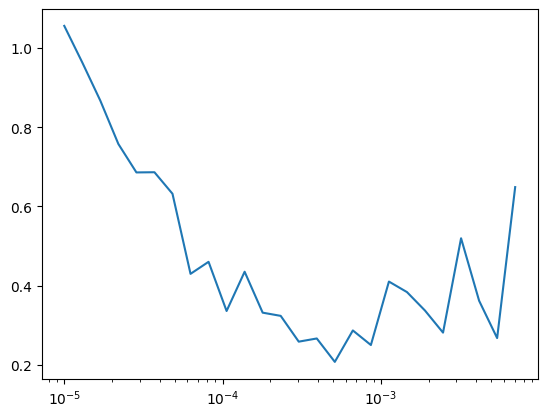

In [9]:
ddpm_cb = DDPMCB()
model = get_model()
learn = TrainLearner(model, dls, CustomMSELoss(), cbs=[ddpm_cb, DeviceCBSparse(), GradientClipCB()], opt_func=torch.optim.Adam)
learn.lr_find(max_mult=3)

In [ ]:
lr = 0.0001 
epochs = 500

model = get_model()

# scheduler
total_steps = epochs * len(dls.train)
sched = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, total_steps = total_steps)

# Callbacks
ddpm_cb = DDPMCB()
checkpoint_cb = CheckpointCB(1000, 'SuperRes', run_params={'msg':model.msg})
cbs = [ddpm_cb, DeviceCBSparse(), ProgressCB(plot=False), LossCB(), GradientClipCB(), checkpoint_cb, BatchSchedCB(sched)]

learn = TrainLearner(model, dls, CustomMSELoss(), lr=lr, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(epochs)

loss,epoch,train
0.440,0,train
0.275,0,eval
0.263,1,train
0.261,1,eval
0.254,2,train
0.243,2,eval
0.238,3,train
0.251,3,eval
0.230,4,train
0.231,4,eval


# Test Super-Resolution

In [ ]:
def denoiseSparseDDPM(model, x0, mask, alpha, alphabar, sigma, start_step=0, n_steps=1000, n_points=4096):
    device = next(model.parameters()).device
    
    x_t = x0.to(device)

    bs = x_t.C[:,0].max() + 1

    for t in tqdm(list(reversed(range(start_step, n_steps)))):

        # creating the time embedding variable
        t_batch = torch.full((bs,), t, device=device, dtype=torch.long)

        # create random noise 
        z = (torch.randn(x_t.F.shape) if t>0 else torch.zeros(x_t.F.shape)).to(device)

        # activate the model to predict the noise
        noise_pred = model((x_t, t_batch))
        
        # calculate the new point coordinates
        pts = x_t.F # previous point coordinates in the continuous space

        a_t, abar_t, s_t = alpha[t], alphabar[t], sigma[t]
        
        new_pts = 1 / math.sqrt(a_t) * (pts - (1 - a_t) / (math.sqrt(1 - abar_t)) * noise_pred) + s_t * z

        new_pts[mask] = pts[mask]
        
        # create a sparse tensor for the next step
        new_pts = new_pts.detach().cpu().reshape(bs, -1, 3)
        
        x_t, mask = sparse_from_pts(new_pts, mask.unsqueeze(0), bs)
        x_t = x_t.to(device)
        mask = mask.F.to(device)
        
    return new_pts.to(device)

In [ ]:
class DDPMScheduler:

    def __init__(self, beta_min, beta_max, n_steps):
        self.n_steps, self.beta_min, self.beta_max = n_steps, beta_min, beta_max
        
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.α = 1. - self.beta 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.beta.sqrt()
        
        self.beta = self.beta.numpy()
        self.α = self.α.numpy()
        self.ᾱ = self.ᾱ.numpy() 
        self.σ = self.σ.numpy()

    def complete_sample(self, model, x0, mask, start_step=0):
        return denoiseSparseDDPM(model, x0, mask, self.α, self.ᾱ, self.σ, start_step, self.n_steps)
    
    def noisify_sample(self, x0, step):

        noise = torch.randn(x0.shape)
        abar_t = self.ᾱ[step]
        xt = np.sqrt(abar_t)*x0 + np.sqrt(1-abar_t)*noise

        return xt

In [ ]:
# get a batch from the validation dataset
batch = next(iter(vl_dl))
vis_batch(batch['noisy_pc'].F.reshape(32, -1, 4)[..., :3])

In [ ]:
# select a model from the batch
pcd = batch['noisy_pc'].F.reshape(32, -1, 4)[..., :3][5]
mask = batch['mask'].reshape(32, -1)[5]
quick_vis_batch(pcd[mask].unsqueeze(0), grid=(1,1))

In [ ]:
# create noise points to add to the clean model
noise = torch.randn_like(pcd)
noise[mask] = pcd[mask]
quick_vis_batch(noise.unsqueeze(0), grid=(1,1))

In [ ]:
def sparse_from_pts(pts, mask, bs, voxel_size=1e-8):

    pts = pts.reshape(bs, -1, 3)

    # make coordinates possitive
    coords = pts - pts.min(dim=1, keepdims=True).values
    coords = coords.numpy()
    
    batch = []
    for b in range(bs):

        c, index = sparse_quantize(coords[b], voxel_size, return_index=True)
        f = pts[b][index]
        m = mask[b][index]
        
        batch.append(
            {'pc':SparseTensor(coords = torch.tensor(c), feats=f),
            'mask':SparseTensor(coords= torch.tensor(c), feats=m)}
        )

    batch = sparse_collate_fn(batch) #['pc']

    return batch['pc'], batch['mask']

In [ ]:
scheduler = DDPMScheduler(beta_min=0.0001, beta_max=0.01, n_steps=1000)

In [ ]:
pc, mask = sparse_from_pts(noise, mask.unsqueeze(0), 1)
mask = mask.F

In [ ]:
preds = scheduler.complete_sample(model, pc, mask)

In [ ]:
from tqdm import tqdm